In [1]:
import json
import numpy as np 
from matplotlib import path as mplPath
import matplotlib.pyplot as plt 

In [2]:
input_fn = f'data/example.in'

usr_input = open(input_fn, 'r').read()

with open(input_fn, 'r') as f:
    agegroups = np.array([int(x) for x in f.readline().split(',')])
    total_budget = float(f.readline())
    popgeo_fn = f.readline().rstrip().replace('\\', '/')
    routegeo_fn = f.readline().rstrip().replace('\\', '/')
    active_fn = f.readline().rstrip().replace('\\', '/')

In [3]:
# Convert age groups to one-hot encoding
num_classes = 6
agegroups_one_hot = np.eye(num_classes)[agegroups]
agegroups_one_hot = agegroups_one_hot.sum(axis=0).reshape(num_classes,1)

for v in agegroups_one_hot:
    assert(v[0] <= 1)

del agegroups

In [4]:
# Get timezone ratio values
import pandas as pd 

df = pd.read_csv(f'{active_fn}')
tz_ratio_array = df.values

del df

In [5]:
with open(f'{routegeo_fn}', 'rb') as f:
    route_data = json.load(f)

with open(f'{popgeo_fn}', 'rb') as f:
    pop_data = json.load(f)

In [6]:
# Preview the first route data
print(route_data['features'][0]['geometry']['coordinates'])
print(route_data['features'][0]['properties'])

[[[139.84984, 35.69470417], [139.84999417, 35.69461861], [139.85028111, 35.69460139], [139.85080778, 35.694597], [139.85153306, 35.6946425], [139.85152709, 35.69506059], [139.85152639, 35.69534556], [139.85150583, 35.69580917], [139.8514925, 35.69590806], [139.85110111, 35.6965025], [139.850898, 35.69680375], [139.85054558, 35.69726027], [139.85037028, 35.69715028], [139.84961977, 35.69639936], [139.84899083, 35.69618083], [139.84865567, 35.69594045], [139.84893347, 35.69561981], [139.84928639, 35.69525972], [139.84984, 35.69470417]], [[139.84856549, 35.68965997], [139.84832833, 35.68977611], [139.84835389, 35.69027], [139.84845152, 35.69089166], [139.84847801, 35.6910603], [139.84848806, 35.6919425], [139.84846651, 35.69225391], [139.84842417, 35.69286583], [139.84841981, 35.69291944], [139.84836139, 35.69363778], [139.84843252, 35.69367635], [139.84984, 35.69470417]]]
{'RouteID': 89, 'Cost': 800000, 'TZ1_Max': 0, 'TZ2_Max': 1, 'TZ3_Max': 1, 'TZ4_Max': 1, 'course_Name': 'AL01', 'lengt

In [7]:
# Preview the first grid data
print(pop_data['features'][0]['geometry']['coordinates'])
print(pop_data['features'][0]['properties'])

[[[[153.975, 24.291666666666668], [153.975, 24.295833333333334], [153.98125, 24.295833333333334], [153.98125, 24.291666666666668], [153.975, 24.291666666666668]]]]
{'MESH_ID': 365337581, 'G1_TZ1': 75.3229, 'G1_TZ2': 63.0104, 'G1_TZ3': 0.0, 'G1_TZ4': 0.0, 'G2_TZ1': 0.0, 'G2_TZ2': 0.0, 'G2_TZ3': 0.0, 'G2_TZ4': 4.5745, 'G3_TZ1': 1.3558, 'G3_TZ2': 9.2874, 'G3_TZ3': 7.5396, 'G3_TZ4': 15.3359, 'G4_TZ1': 15.5649, 'G4_TZ2': 4.2374, 'G4_TZ3': 4.2073, 'G4_TZ4': 354089463.7822, 'G5_TZ1': 16.1953, 'G5_TZ2': 4.2566, 'G5_TZ3': 3.9962, 'G5_TZ4': 4.1598, 'G6_TZ1': 16.1567, 'G6_TZ2': 4.5224, 'G6_TZ3': 4.4152, 'G6_TZ4': 4.1574}


In [8]:
# Create Route and Grid classes for readability
class Route:
    def __init__(self, route_id, coords, cost, tz_max_buses_dict):
        self.route_id = route_id
        self.coords = np.array(self.flattenCoords(coords))
        self.cost = float(cost)
        self.tz_max_buses_dict = self.convertToMaxPerTz(tz_max_buses_dict)
        self.pop_per_tz_agegroup_array = np.zeros((6,4))
        
    def flattenCoords(self, coords):
        return [ coord for sublist in coords for coord in sublist ]

    def convertToMaxPerTz(self, tz_max_buses_dict):
        # Multiply the max value per hour by the number of hours in the tz
        tz_max_buses_dict['TZ1_Max'] = int(tz_max_buses_dict['TZ1_Max'] * 10)
        tz_max_buses_dict['TZ2_Max'] = int(tz_max_buses_dict['TZ2_Max'] *2)
        tz_max_buses_dict['TZ3_Max'] = int(tz_max_buses_dict['TZ3_Max'] * 8)
        tz_max_buses_dict['TZ4_Max'] = int(tz_max_buses_dict['TZ4_Max'] * 4)
        return tz_max_buses_dict
    
    def updateGridsInside(self, grids_dict):
        self.grid_ids = []
        for key,grid in grids_dict.items():
            if any(grid.containsPoints(self.coords)):
                self.grid_ids.append(key)
    
    def updatePopPerTZVector(self, grids_dict):
        assert(len(self.grid_ids) > 0)
        
        for grid_id in self.grid_ids:
            self.pop_per_tz_agegroup_array += grids_dict[grid_id].agegroup_tz_array
        
        self.pop_per_tz_vector = self.pop_per_tz_agegroup_array.sum(axis=0)

In [9]:
class Grid:
    def __init__(self, mesh_id, path, agegroup_tz_array, tz_ratio_array, agegroups_one_hot):
        self.mesh_id = mesh_id
        self.path = self.convertPath(path)
        self.agegroup_tz_array = agegroup_tz_array*tz_ratio_array*agegroups_one_hot
    
    def convertPath(self, path):
        # Flatten first
        while True:
            if len(path) == 1:
                path = path[0]
            else:
                break
        return mplPath.Path(np.array(path), closed=True) # Convert to mpl Path object
    
    def containsPoint(self, point):
        return self.path.contains_point(point)
    
    def containsPoints(self, points):
        return self.path.contains_points(points)

In [10]:
routes = []
for feature in route_data['features']:
    route_id = feature['properties']['RouteID']
    coords = feature['geometry']['coordinates']
    cost = feature['properties']['Cost']
    tz_max_buses_dict = { k:feature['properties'][k] for k in ['TZ1_Max','TZ2_Max','TZ3_Max','TZ4_Max'] }
    routes.append(Route(route_id, coords, cost, tz_max_buses_dict))
    
del route_data

In [11]:
grids_dict = {}
for feature in pop_data['features']:
    mesh_id = feature['properties']['MESH_ID']
    path = feature['geometry']['coordinates']
    agegroup_tz_array = np.array([[ feature['properties']['G1_TZ1'], feature['properties']['G1_TZ2'], feature['properties']['G1_TZ3'], feature['properties']['G1_TZ4'] ],
                                  [ feature['properties']['G2_TZ1'], feature['properties']['G2_TZ2'], feature['properties']['G2_TZ3'], feature['properties']['G2_TZ4'] ],
                                  [ feature['properties']['G3_TZ1'], feature['properties']['G3_TZ2'], feature['properties']['G3_TZ3'], feature['properties']['G3_TZ4'] ],
                                  [ feature['properties']['G4_TZ1'], feature['properties']['G4_TZ2'], feature['properties']['G4_TZ3'], feature['properties']['G4_TZ4'] ],
                                  [ feature['properties']['G5_TZ1'], feature['properties']['G5_TZ2'], feature['properties']['G5_TZ3'], feature['properties']['G5_TZ4'] ],
                                  [ feature['properties']['G6_TZ1'], feature['properties']['G6_TZ2'], feature['properties']['G6_TZ3'], feature['properties']['G6_TZ4'] ]])
    grids_dict[str(mesh_id)] = Grid(mesh_id, path, agegroup_tz_array, tz_ratio_array, agegroups_one_hot)

In [12]:
print(f'Number of Routes: {len(routes)}')
print(f'Number of Grids: {len(grids_dict)}')

Number of Routes: 152
Number of Grids: 5311


In [13]:
for route in routes:
    route.updateGridsInside(grids_dict)

print(f'Example for first routes\' grid_ids: {routes[0].grid_ids}')

Example for first routes' grid_ids: ['533946274', '533946372', '533946374', '533946381', '533946383']


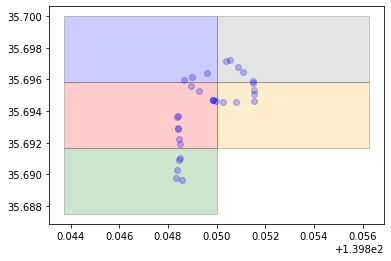

In [14]:
# Test our Grids and ability to detect points inside/outside with the first route
import matplotlib.patches as patches
from matplotlib.collections import PathCollection

points = routes[0].coords

fig, ax = plt.subplots()

colors = ['green', 'red', 'blue', 'orange', 'grey']
for i,grid_id in enumerate(routes[0].grid_ids):
    ax.add_patch(patches.PathPatch(grids_dict[grid_id].path, facecolor=colors[i], lw=1, alpha=0.2))

for point in points:
    ax.plot(point[0], point[1], 'bo', alpha=0.25)

ax.autoscale_view()
plt.show()

In [15]:
for route in routes:
    route.updatePopPerTZVector(grids_dict)

del grids_dict

In [16]:
# Preview the first route's population outside by its agegroup and timezone array
# Note: we have already removed agegroups we are not interested in
print(f'First route\'s route_id: {routes[0].route_id}')
print(f'First route\'s agegroup_tz_per_cost_array:')
print(routes[0].pop_per_tz_vector)

# agegroup_tz_per_cost_array structure:
# np.array(['pop_per_cost_unit_TZ1','pop_per_cost_unit_TZ2','pop_per_cost_unit_TZ3','pop_per_cost_unit_TZ4'])

First route's route_id: 89
First route's agegroup_tz_per_cost_array:
[ 798.20554 3117.67232 1788.51936 3649.35648]


In [17]:
# Combine all route and tz data into a DataFrame for easy analysis
routes_by_tz_df = pd.DataFrame()
for route in routes:
    for tz_idx,total_pop in enumerate(route.pop_per_tz_vector):
        if total_pop > 0:
            routes_by_tz_df = routes_by_tz_df.append({'route_id':route.route_id, 
                                                      'tz':tz_idx+1,
                                                      'cost':route.cost,
                                                      'total_pop':total_pop,
                                                      'max_buses':route.tz_max_buses_dict[f'TZ{tz_idx+1}_Max']}, ignore_index=True)

routes_by_tz_df['pop_per_cost'] = routes_by_tz_df['total_pop'] / routes_by_tz_df['cost']
routes_by_tz_df = routes_by_tz_df.sort_values('pop_per_cost', ascending=False).reset_index(drop=True)

In [18]:
print(routes_by_tz_df.head())

        cost  max_buses  route_id    total_pop   tz  pop_per_cost
0   600000.0        4.0     142.0  21563.90112  4.0      0.035940
1   600000.0        2.0     142.0  20159.07952  2.0      0.033598
2   800000.0        4.0     126.0  25518.22368  4.0      0.031898
3  1200000.0        8.0      72.0  34638.65248  4.0      0.028866
4   800000.0        4.0     100.0  22695.75824  4.0      0.028370


In [19]:
min_cost = min(routes_by_tz_df.cost)

budget_left = total_budget

rte_ids, tzs = [],[]
for i,row in routes_by_tz_df.iterrows():
    if budget_left < min_cost:
        break
        
    max_buses = row['max_buses']
    while (budget_left > row['cost'] and max_buses > 0):
        rte_ids.append(int(row['route_id']))
        tzs.append(int(row['tz']))
        budget_left -= row['cost']
        max_buses -= 1

In [20]:
for i in range(len(rte_ids)):
    print(f'{rte_ids[i]}, {tzs[i]}')

142, 4
142, 4
142, 4
142, 4
142, 2
142, 2
126, 4
126, 4
126, 4
126, 4
72, 4
72, 4
142, 3


In [21]:
print(total_budget)
print(budget_left)
print(min_cost)

10000000.0
200000.0
600000.0
